# Preamble

In [1]:
import os
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import obspy
import re

In [2]:
# Some utility functions

def read_trace(filename):
    """Reads an ASCII file and returns a obspy Traces"""
    data = np.loadtxt(filename)
    # first column is time, second column is the data
    times = data[:, 0]
    disp = data[:, 1]
    # get station name from the filename
    net, sta, comp, *_ = filename.split("/")[-1].split(".")
    delta = times[1] - times[0]
    headers = {"station": sta, "network": net, "channel": comp, "delta": delta, "b": times[0]}
    return obspy.Trace(disp, headers)


def save_trace(tr, filename):
    """Writes out the traces as an ASCII file. Uses b value as the beginning."""
    data = np.zeros((len(tr.data), 2))
    data[:, 0] = tr.times()+tr.stats.b
    data[:, 1] = tr.data
    np.savetxt(filename, data)
    
    
def specfem_write_parameters(filename, parameters, output_file=None):
    """Write parameters to a specfem config file"""

    with open(filename) as f:
        pars = f.read()

    for varname, value in parameters.items():
        pat = re.compile(
            r"(^{varname}\s*=\s*)([^#$\s]+)".format(varname=varname),
            re.MULTILINE)
        pars = pat.sub(r"\g<1>{value}".format(value=value), pars)

    if output_file is None:
        output_file = filename

    with open(output_file, "w") as f:
        f.write(pars)
        
        
def specfem2D_prep_save_forward(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 1,
        "SAVE_FORWARD": ".true."
    }
    specfem_write_parameters(filename, params)
    
def specfem2D_prep_adjoint(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 3,
        "SAVE_FORWARD": ".false."
    }
    specfem_write_parameters(filename, params)
    

    
def grid(x, y, z, resX=100, resY=100):
    """
    Converts 3 column data to matplotlib grid
    """
    # Can be found in ./utils/Visualization/plot_kernel.py
    from scipy.interpolate import griddata

    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    # mlab version
    #Z = griddata(x, y, z, xi, yi, interp='linear')
    # scipy version
    Z = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z


# Setting up Specfem2D

You can find the Specfem2D package on [GitHub](https://github.com/geodynamics/specfem2d). You can download it from the website or using `git`. This application uses `devel` branch.

```sh
git clone --branch=devel https://github.com/geodynamics/specfem2d.git
```

Compile it using:
```sh
cd specfem2d
./configure
make
```

In [3]:
# Set the directory path for executable files
specfem2d_path = "./specfem2d/bin"

# Setting up the model

In the `DATA/Par_file` following is set:


```toml
# set the type of calculation (P-SV or SH/membrane waves)
P_SV                            = .false.

...

# seismogram formats
save_ASCII_seismograms          = .true.         # save seismograms in ASCII format or not

...

# use an existing STATION file found in ./DATA or create a new one from the receiver positions below in this Par_file
use_existing_STATIONS           = .true.

# save sensitivity kernels in ASCII format (much bigger files, but compatible with current GMT scripts) or in binary format
save_ASCII_kernels              = .true.

...

# Stacey ABC
STACEY_ABSORBING_CONDITIONS     = .true.

...

# number of model materials
nbmodels                        = 4
1 1 2700.d0 3000.d0 1800.0d0 0 0 9999 9999 0 0 0 0 0 0

...

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = interfaces.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .true.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions                       = 1              # then set below the different regions and model number for each region
# format of each line: nxmin nxmax nzmin nzmax material_number
1 80  1 80 1
```

We have a homogenenous model with width and height of 4000 meters and relevant model parameters are $\rho=2700~g/cm^3$ and $V_s=1800~m/s$.

## Source and Stations

Source parameters are set in the `DATA/SOURCE` file:

```toml
# location:
xs                              = 1000. 
zs                              = 2000.

...

# Force
source_type                     = 1  

...

# Ricker wavelet
time_function_type=1

# dominant source frequency (Hz)
f0                              = 10.0
```


Station information is set in `DATA/STATIONS` file:

```
# network station    x                   z                  not used in 2D
S0001    AA          3000.0000000        2000.0000000       0.0         0.0
```

# Forward Simulation

To keep the last frame for adjoint simulation, following `DATA/Par_file` needs be set

```toml
SIMULATION_TYPE                 = 1
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.
```

`specfem2D_prep_save_forward` function can be used for this purpose.

In [4]:
# Prepare Par_file
specfem2D_prep_save_forward()
# Create the OUTPUT_FILES directory if needed
os.makedirs("OUTPUT_FILES", exist_ok=True)

In [5]:
# Run the mesher
!$specfem2d_path/xmeshfem2D


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to commit cf89366717d9435985ba852ef1d41a10cee97884
 dating From Date:   Mon Nov 29 23:20:51 2021 -0800

 Reading the parameter file...

 Title of the simulation: Simple Kernel


 Receiver lines:
   Nb of line sets =            2

   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            1  receivers

 Materials:
   Nb of solid, fluid or porous materials =            4

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2700.0000000000000        3000.0000000000000        1800.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    2500.0000000000000        2700.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000

In [6]:
# Run the solver
!$specfem2d_path/xspecfem2D


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to commit cf89366717d9435985ba852ef1d41a10cee97884
 dating From Date:   Mon Nov 29 23:20:51 2021 -0800


 NDIM =            2

 NGLLX =            5
 NGLLZ =            5

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38

 Reading the parameter file...

 Title of the simulation: Simple Kernel


   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            1  receivers

 Parameter file successfully read 

 Reading in SOURCE file...

 Source           1
   Position xs, zs =    1000.0000000000000        2000.0000000000000     

   Source type (1=force, 2=moment tensor):            1
   Force source:
   Angle of the source (deg) =    0.0000000000000000     

   Time functi

# Plotting the seismograms

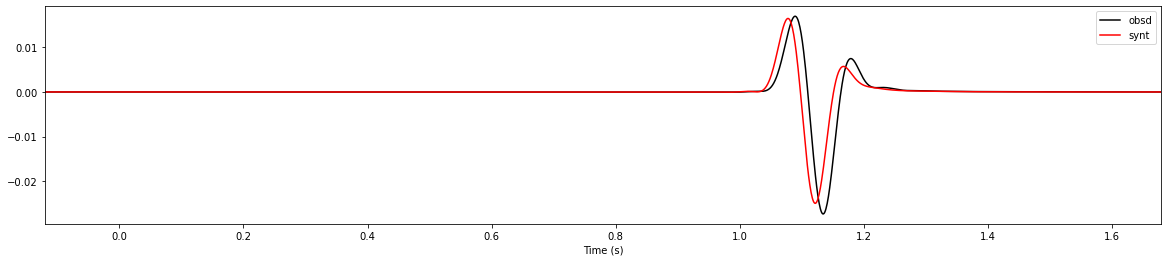

In [7]:
obsd = read_trace("./AA.S0001.BXY.obsd.semd")
synt = read_trace("./OUTPUT_FILES/AA.S0001.BXY.semd")

# Process data
obsd.detrend("simple")
obsd.taper(0.05)
obsd.filter("bandpass", freqmin=0.01, freqmax=20, zerophase=True)

synt.detrend("simple")
synt.taper(0.05)
synt.filter("bandpass", freqmin=0.01, freqmax=20, zerophase=True)


fig, ax = plt.subplots(figsize=(20, 4))

# Use the beginning time value from the file.
# by using tr.times()+tr.stats.b
ax.plot(obsd.times()+obsd.stats.b, obsd.data, "k", label="obsd")
ax.plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")

ax.set_xlim(obsd.stats.b, obsd.times()[-1]+obsd.stats.b)

ax.legend()
ax.set_xlabel("Time (s)");

# Misfit Calculation and Adjoint Source

For one seismogram, waveform misfit is

$$ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~, $$


and waveform adjoint source is

$$  f^\dagger (t) = s(t) - d(t)~,$$

where $s(t)$ is the synthetic, $d(t)$ is the observed seismograms.

In [8]:
# Misfit
misfit = 0.5*simps((obsd.data-synt.data)**2, dx=obsd.stats.delta)
print(f"Misfit: {misfit:.6f}")

Misfit: 0.000006


In [9]:
# Adjoint Source
adj = synt.copy()
adj.data = synt.data - obsd.data

# Process
adj.detrend("simple")
adj.taper(0.05)
adj.filter("bandpass", freqmin=0.01, freqmax=20, zerophase=True)

AA.S0001..BXY | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.799000Z | 1000.0 Hz, 1800 samples

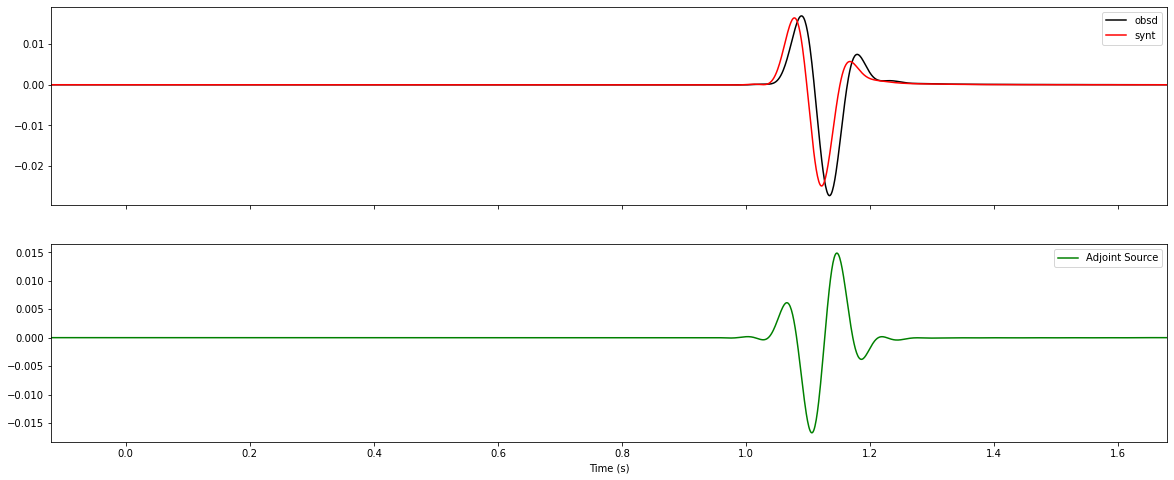

In [10]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
axes[0].plot(obsd.times()+obsd.stats.b, obsd.data, "k", label="obsd")
axes[0].plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")
axes[0].set_xlim(obsd.stats.b, obsd.times()[-1]+obsd.stats.b)
axes[0].legend()

axes[1].plot(adj.times()+adj.stats.b, adj.data, "g", label="Adjoint Source")

axes[1].legend()

axes[1].set_xlabel("Time (s)");

In [11]:
# Save adjoint source to SEM directory
os.makedirs("SEM", exist_ok=True)
save_trace(adj, "SEM/AA.S0001.BXY.adj")

# Adjoint Simulation

For adjoint simulation, following `DATA/Par_file` needs be set

```toml
SIMULATION_TYPE                 = 3
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.
```

`specfem2D_prep_adjoint` function can be used for this purpose.

In [12]:
# Prepare Par_file
specfem2D_prep_adjoint()

In [13]:
# Run the solver
!$specfem2d_path/xspecfem2D


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to commit cf89366717d9435985ba852ef1d41a10cee97884
 dating From Date:   Mon Nov 29 23:20:51 2021 -0800


 NDIM =            2

 NGLLX =            5
 NGLLZ =            5

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38

 Reading the parameter file...

 Title of the simulation: Simple Kernel


   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            1  receivers

 Parameter file successfully read 

 Reading in SOURCE file...

 Source           1
   Position xs, zs =    1000.0000000000000        2000.0000000000000     

   Source type (1=force, 2=moment tensor):            1
   Force source:
   Angle of the source (deg) =    0.0000000000000000     

   Time functi

# Plotting the Kernels

`./OUTPUT_FILES/proc000000_rhop_alpha_beta_kernel.dat` file holds the kernel data.

It is a text file contains 5 columns: `x`, `z`, `rhop`, `alpha`, `beta`.

In [14]:
data = np.loadtxt("./OUTPUT_FILES/proc000000_rhop_alpha_beta_kernel.dat")

# first column: x
x = data[:, 0]
# second column: z
z = data[:, 1]
# fifth column: beta_kernel
beta = data[:, 4]

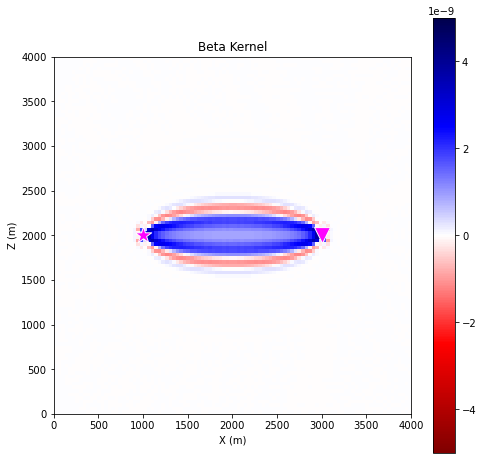

In [15]:
# For plotting, you can check: specfem2D/utils/Visualization/plot_kernel.py

# First we need to get the data into proper format
X, Z, BETA = grid(x, z, beta)

# vmax = np.max(np.abs(beta))
vmax = 5e-9

fig, ax = plt.subplots(figsize=(8, 8))



im = ax.imshow(BETA, vmax=vmax, vmin=-vmax, extent=[x.min(), x.max(), z.min(), z.max()],
               cmap="seismic_r")
ax.set_xlabel("X (m)")
ax.set_ylabel("Z (m)")
ax.set_title("Beta Kernel")


# Plot source and station
ax.scatter(1000, 2000, 300, marker="*", color="magenta", edgecolor="white")
ax.scatter(3000, 2000, 250, marker="v", color="magenta", edgecolor="white")

plt.colorbar(im, ax=ax);